In [1]:
pretty = True
highres = True

%matplotlib inline
if highres:
    %config InlineBackend.figure_format = 'retina'
else:
    %config InlineBackend.figure_format = 'png'

#rcParams["figure.dpi"]=300

import sys
from pathlib import Path

pypsapath = "C:/dev/py/PyPSA/"

if sys.path[0] != pypsapath:
    sys.path.insert(0,pypsapath)

if Path("../..") not in [Path(p) for p in sys.path]:
    sys.path.insert(0,"../..")

%load_ext autoreload
%autoreload 2

In [2]:
import src.globals
from src.scigridnetwork import SciGRID_network
from src.armafitloader import ARMAfit_loader
import src.plothelper

Git root path found at: C:\dev\grid-analysis
Using data path:        C:\dev\grid-analysis\data


In [77]:
import pypsa
import numpy as np
import pandas as pd
import os
import itertools
import scipy.stats
from tqdm import tqdm

import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib.dates
import matplotlib.font_manager
from matplotlib import rcParams

rcParams["font.family"] = "sans-serif"


from IPython.display import Markdown, display
printm = lambda s: display(Markdown(s))

In [4]:
sgn = SciGRID_network()
fav_sgn = sgn

Importing PyPSA from older version of PyPSA than current version 0.13.2.
Please read the release notes at https://pypsa.org/doc/release_notes.html
carefully to prepare your network for import.



0.13.2 ['C:/dev/py/PyPSA\\pypsa']


In [5]:
month_index = 0
month_name = ARMAfit_loader.monthnames[month_index]

solar_diff_cov = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "solar_diffdaylightcov.npy")
wind_diff_cov = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "wind_diffcov.npy")
solar_diff_cov_norm = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "solar_diffdaylightcovnorm.npy")
wind_diff_cov_norm = np.load(src.globals.data_path / "processed" / "covariance" / month_name / "wind_diffcovnorm.npy")

In [6]:
bus_diff_cov_day = wind_diff_cov + solar_diff_cov
bus_diff_cov_night = wind_diff_cov
bus_diff_cov_day_norm = wind_diff_cov_norm + solar_diff_cov_norm
bus_diff_cov_night_norm = wind_diff_cov_norm

In [7]:
line_diff_cov_day = sgn.F @ bus_diff_cov_day @ sgn.F.T
line_diff_cov_night = sgn.F @ bus_diff_cov_night @ sgn.F.T
line_diff_cov_day_norm = sgn.F @ bus_diff_cov_day_norm @ sgn.F.T
line_diff_cov_night_norm = sgn.F @ bus_diff_cov_night_norm @ sgn.F.T

In [8]:
sgn.run_lopf_jan1()

Performing linear OPF for one day, 4 snapshots at a time:


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:39<00:00,  6.43s/it]


In [57]:
ratings = []
times = fav_sgn.injection_total.index
for t, time in enumerate(times):
    bus_cov = bus_diff_cov_day if fav_sgn.isdaylighthour[t] else bus_diff_cov_night
    rating = sgn.get_line_ratings(bus_cov, time=time)
    ratings.append(rating)

In [58]:
for time, rating in zip(times, ratings):
    print(time)
    display(rating.sort_values("P>1", ascending=False).head(10))

2011-01-01 00:00:00


,l,f,σ,P>1,rate
54,[58],0.700000,0.194037,0.061040,1.195213
298,[361],-0.700000,0.164237,0.033878,1.668283
25,[27],-0.694584,0.126700,0.007964,2.905377
651,[809],0.700000,0.116080,0.004877,3.339599
315,"[389, 390]",0.699914,0.105408,0.002207,4.052426
531,[660],-0.354092,0.205282,0.000826,4.950038
652,[810],-0.634429,0.115574,0.000780,5.002594
534,"[669, 670]",-0.626573,0.103687,0.000158,6.485369
564,[715],-0.700000,0.080065,0.000089,7.019866
18,[20],-0.601197,0.102293,0.000048,7.599610


2011-01-01 01:00:00


,l,f,σ,P>1,rate
298,[361],-0.700000,0.164237,0.033878,1.668283
54,[58],0.621422,0.194037,0.025525,1.903332
25,[27],-0.691017,0.126700,0.007370,2.973645
651,[809],0.700000,0.116080,0.004877,3.339599
315,"[389, 390]",0.699914,0.105408,0.002207,4.052426
652,[810],-0.658309,0.115574,0.001556,4.370367
531,[660],-0.371220,0.205282,0.001096,4.690988
337,[427],-0.443279,0.159541,0.000242,6.088390
534,"[669, 670]",-0.626573,0.103687,0.000158,6.485369
18,[20],-0.617482,0.102293,0.000092,6.991629


2011-01-01 02:00:00


,l,f,σ,P>1,rate
298,[361],-0.700000,0.164237,0.033878,1.668283
54,[58],0.598907,0.194037,0.019362,2.136453
651,[809],0.700000,0.116080,0.004877,3.339599
652,[810],-0.674350,0.115574,0.002419,3.969669
315,"[389, 390]",0.699914,0.105408,0.002207,4.052426
531,[660],-0.394304,0.205282,0.001586,4.352871
337,[427],-0.476059,0.159541,0.000512,5.392529
25,[27],-0.567646,0.126700,0.000322,5.822352
534,"[669, 670]",-0.626573,0.103687,0.000158,6.485369
564,[715],-0.700000,0.080065,0.000089,7.019866


2011-01-01 03:00:00


,l,f,σ,P>1,rate
298,[361],-0.700000,0.164237,0.033878,1.668283
54,[58],0.590005,0.194037,0.017301,2.232342
651,[809],0.700000,0.116080,0.004877,3.339599
652,[810],-0.692064,0.115574,0.003856,3.549546
315,"[389, 390]",0.699914,0.105408,0.002207,4.052426
531,[660],-0.410300,0.205282,0.002035,4.125999
337,[427],-0.503175,0.159541,0.000923,4.848794
534,"[669, 670]",-0.626573,0.103687,0.000158,6.485369
564,[715],-0.700000,0.080065,0.000089,7.019866
561,[712],-0.700000,0.078530,0.000067,7.296926


2011-01-01 04:00:00


,l,f,σ,P>1,rate
298,[361],-0.700000,0.164237,0.033878,1.668283
54,[58],0.577718,0.194037,0.014766,2.368146
651,[809],0.700000,0.116080,0.004877,3.339599
652,[810],-0.700000,0.115574,0.004719,3.368947
337,[427],-0.551496,0.159541,0.002468,3.951477
531,[660],-0.422607,0.205282,0.002457,3.955574
315,"[389, 390]",0.699914,0.105408,0.002207,4.052426
20,[22],0.660929,0.104603,0.000595,5.253644
534,"[669, 670]",-0.626573,0.103687,0.000158,6.485369
564,[715],-0.700000,0.080065,0.000089,7.019866


2011-01-01 05:00:00


,l,f,σ,P>1,rate
337,[427],-0.677879,0.159541,0.021741,2.038287
54,[58],0.553829,0.194037,0.010741,2.643655
651,[809],0.700000,0.116080,0.004877,3.339599
652,[810],-0.700000,0.115574,0.004719,3.368947
298,[361],-0.561592,0.164237,0.003800,3.562743
315,"[389, 390]",0.699914,0.105408,0.002207,4.052426
531,[660],-0.400154,0.205282,0.001739,4.269198
534,"[669, 670]",-0.626573,0.103687,0.000158,6.485369
564,[715],-0.700000,0.080065,0.000089,7.019866
569,[720],-0.700000,0.076673,0.000046,7.654722


2011-01-01 06:00:00


,l,f,σ,P>1,rate
298,[361],-0.700000,0.164237,0.033878,1.668283
54,[58],0.537587,0.194037,0.008583,2.839639
651,[809],0.700000,0.116080,0.004877,3.339599
652,[810],-0.700000,0.115574,0.004719,3.368947
315,"[389, 390]",0.699914,0.105408,0.002207,4.052426
337,[427],-0.522474,0.159541,0.001381,4.479404
531,[660],-0.295259,0.205282,0.000298,5.892848
534,"[669, 670]",-0.626573,0.103687,0.000158,6.485369
20,[22],0.616606,0.104603,0.000124,6.716905
564,[715],-0.700000,0.080065,0.000089,7.019866


2011-01-01 07:00:00


,l,f,σ,P>1,rate
298,[361],-0.700000,0.164237,0.033878,1.668283
54,[58],0.536548,0.194037,0.008459,2.852411
25,[27],-0.694649,0.126700,0.007975,2.904153
651,[809],0.700000,0.116080,0.004877,3.339599
652,[810],-0.700000,0.115574,0.004719,3.368947
315,"[389, 390]",0.666314,0.105408,0.000774,5.010720
534,"[669, 670]",-0.625515,0.103687,0.000152,6.522176
18,[20],-0.629491,0.102293,0.000146,6.559506
564,[715],-0.700000,0.080065,0.000089,7.019866
531,[660],-0.213720,0.205282,0.000064,7.335360


2011-01-01 08:00:00


,l,f,σ,P>1,rate
652,[810],-0.700000,0.237297,0.103072,0.799150
651,[809],0.700000,0.229494,0.095568,0.854420
411,[516],-0.700000,0.203939,0.070642,1.081965
473,[584],0.416169,0.338016,0.042078,1.491655
298,[361],-0.700000,0.165036,0.034548,1.652178
54,[58],0.528406,0.250550,0.029902,1.771400
213,[249],-0.700000,0.151372,0.023747,1.963915
25,[27],-0.700000,0.147734,0.021144,2.061833
645,[803],-0.700000,0.146402,0.020223,2.099520
44,[48],-0.700000,0.135294,0.013298,2.458412


2011-01-01 09:00:00


,l,f,σ,P>1,rate
652,[810],-0.700000,0.237297,0.103072,0.799150
651,[809],0.700000,0.229494,0.095568,0.854420
411,[516],-0.700000,0.203939,0.070642,1.081965
473,[584],0.414151,0.338016,0.041545,1.501985
298,[361],-0.700000,0.165036,0.034548,1.652178
54,[58],0.529174,0.250550,0.030111,1.765634
213,[249],-0.700000,0.151372,0.023747,1.963915
25,[27],-0.700000,0.147734,0.021144,2.061833
645,[803],-0.700000,0.146402,0.020223,2.099520
251,[302],-0.700000,0.140522,0.016385,2.278904


2011-01-01 10:00:00


,l,f,σ,P>1,rate
652,[810],-0.696699,0.237297,0.100598,0.816834
651,[809],0.700000,0.229494,0.095568,0.854420
411,[516],-0.700000,0.203939,0.070642,1.081965
473,[584],0.395884,0.338016,0.036968,1.597114
298,[361],-0.700000,0.165036,0.034548,1.652178
213,[249],-0.700000,0.151372,0.023747,1.963915
25,[27],-0.700000,0.147734,0.021144,2.061833
54,[58],0.487742,0.250550,0.020450,2.090057
645,[803],-0.700000,0.146402,0.020223,2.099520
251,[302],-0.700000,0.140522,0.016385,2.278904


2011-01-01 11:00:00


,l,f,σ,P>1,rate
651,[809],0.700000,0.229494,0.095568,0.854420
652,[810],-0.681245,0.237297,0.089591,0.902194
411,[516],-0.700000,0.203939,0.070642,1.081965
54,[58],0.614813,0.250550,0.062102,1.181745
298,[361],-0.700000,0.165036,0.034548,1.652178
473,[584],0.370513,0.338016,0.031306,1.734079
213,[249],-0.700000,0.151372,0.023747,1.963915
25,[27],-0.700000,0.147734,0.021144,2.061833
645,[803],-0.700000,0.146402,0.020223,2.099520
74,[80],-0.429590,0.276626,0.019603,2.125974


2011-01-01 12:00:00


,l,f,σ,P>1,rate
54,[58],0.700000,0.250550,0.115582,0.716842
74,[80],-0.666534,0.276626,0.114010,0.726584
651,[809],0.700000,0.229494,0.095568,0.854420
411,[516],-0.700000,0.203939,0.070642,1.081965
652,[810],-0.650579,0.237297,0.070442,1.084137
298,[361],-0.700000,0.165036,0.034548,1.652178
213,[249],-0.700000,0.151372,0.023747,1.963915
25,[27],-0.700000,0.147734,0.021144,2.061833
645,[803],-0.700000,0.146402,0.020223,2.099520
473,[584],0.283864,0.338016,0.017133,2.244327


2011-01-01 13:00:00


,l,f,σ,P>1,rate
54,[58],0.684851,0.250550,0.104227,0.791063
651,[809],0.700000,0.229494,0.095568,0.854420
652,[810],-0.665246,0.237297,0.079167,0.995036
411,[516],-0.700000,0.203939,0.070642,1.081965
298,[361],-0.700000,0.165036,0.034548,1.652178
74,[80],-0.454719,0.276626,0.024352,1.942782
213,[249],-0.700000,0.151372,0.023747,1.963915
25,[27],-0.700000,0.147734,0.021144,2.061833
645,[803],-0.700000,0.146402,0.020223,2.099520
289,[350],0.641725,0.171730,0.018477,2.176262


2011-01-01 14:00:00


,l,f,σ,P>1,rate
74,[80],-0.673648,0.276626,0.119048,0.695917
651,[809],0.700000,0.229494,0.095568,0.854420
54,[58],0.643494,0.250550,0.077384,1.012311
652,[810],-0.659654,0.237297,0.075749,1.028556
411,[516],-0.700000,0.203939,0.070642,1.081965
289,[350],0.700000,0.171730,0.040325,1.525878
298,[361],-0.700000,0.165036,0.034548,1.652178
213,[249],-0.700000,0.151372,0.023747,1.963915
416,[521],-0.639147,0.180463,0.022772,1.999189
25,[27],-0.700000,0.147734,0.021144,2.061833


2011-01-01 15:00:00


,l,f,σ,P>1,rate
74,[80],-0.700000,0.276626,0.139072,0.588066
651,[809],0.700000,0.229494,0.095568,0.854420
411,[516],-0.700000,0.203939,0.070642,1.081965
652,[810],-0.650453,0.237297,0.070371,1.084918
416,[521],-0.685678,0.180463,0.040776,1.516852
289,[350],0.700000,0.171730,0.040325,1.525878
54,[58],0.556232,0.250550,0.038266,1.568526
298,[361],-0.700000,0.165036,0.034548,1.652178
213,[249],-0.700000,0.151372,0.023747,1.963915
25,[27],-0.700000,0.147734,0.021144,2.061833


2011-01-01 16:00:00


,l,f,σ,P>1,rate
298,[361],-0.700000,0.164237,0.033878,1.668283
54,[58],0.588798,0.194037,0.017037,2.245502
25,[27],-0.700000,0.126700,0.008947,2.803255
651,[809],0.700000,0.116080,0.004877,3.339599
74,[80],-0.700000,0.110374,0.003284,3.693840
652,[810],-0.639668,0.115574,0.000911,4.860225
315,"[389, 390]",0.626931,0.105408,0.000201,6.263279
18,[20],-0.574374,0.102293,0.000016,8.656280
337,[427],-0.329762,0.159541,0.000013,8.824397
17,[19],-0.700000,0.071304,0.000013,8.850849


2011-01-01 17:00:00


,l,f,σ,P>1,rate
54,[58],0.648174,0.194037,0.034901,1.643833
298,[361],-0.700000,0.164237,0.033878,1.668283
25,[27],-0.700000,0.126700,0.008947,2.803255
651,[809],0.700000,0.116080,0.004877,3.339599
74,[80],-0.700000,0.110374,0.003284,3.693840
652,[810],-0.634245,0.115574,0.000776,5.007619
337,[427],-0.449832,0.159541,0.000282,5.945900
315,"[389, 390]",0.607774,0.105408,0.000099,6.923043
17,[19],-0.700000,0.071304,0.000013,8.850849
18,[20],-0.566046,0.102293,0.000011,8.998343


2011-01-01 18:00:00


,l,f,σ,P>1,rate
298,[361],-0.700000,0.164237,0.033878,1.668283
25,[27],-0.700000,0.126700,0.008947,2.803255
54,[58],0.518016,0.194037,0.006496,3.085090
651,[809],0.700000,0.116080,0.004877,3.339599
74,[80],-0.700000,0.110374,0.003284,3.693840
652,[810],-0.632255,0.115574,0.000732,5.062260
17,[19],-0.700000,0.071304,0.000013,8.850849
315,"[389, 390]",0.545224,0.105408,0.000008,9.307217
18,[20],-0.544371,0.102293,0.000004,9.919652
337,[427],-0.280418,0.159541,0.000003,10.171551


2011-01-01 19:00:00


,l,f,σ,P>1,rate
298,[361],-0.700000,0.164237,3.387795e-02,1.668283
25,[27],-0.700000,0.126700,8.946937e-03,2.803255
651,[809],0.695685,0.116080,4.376117e-03,3.436350
74,[80],-0.700000,0.110374,3.283608e-03,3.693840
54,[58],0.470716,0.194037,3.188374e-03,3.720316
652,[810],-0.635465,0.115574,8.048889e-04,4.974266
315,"[389, 390]",0.556700,0.105408,1.302131e-05,8.843405
17,[19],-0.700000,0.071304,1.291980e-05,8.850849
531,[660],-0.051064,0.205282,2.047619e-06,10.684152
18,[20],-0.462437,0.102293,7.396751e-08,13.808097


2011-01-01 20:00:00


,l,f,σ,P>1,rate
298,[361],-0.700000,0.164237,3.387795e-02,1.668283
25,[27],-0.700000,0.126700,8.946937e-03,2.803255
651,[809],0.700000,0.116080,4.877228e-03,3.339599
74,[80],-0.700000,0.110374,3.283608e-03,3.693840
54,[58],0.458434,0.194037,2.626868e-03,3.894980
652,[810],-0.642012,0.115574,9.758607e-04,4.797198
315,"[389, 390]",0.561780,0.105408,1.609611e-05,8.641893
17,[19],-0.700000,0.071304,1.291980e-05,8.850849
531,[660],-0.041977,0.205282,1.722143e-06,10.889763
564,[715],-0.607709,0.080065,4.799959e-07,12.003369


2011-01-01 21:00:00


,l,f,σ,P>1,rate
298,[361],-0.700000,0.164237,3.387795e-02,1.668283
25,[27],-0.700000,0.126700,8.946937e-03,2.803255
651,[809],0.700000,0.116080,4.877228e-03,3.339599
74,[80],-0.700000,0.110374,3.283608e-03,3.693840
54,[58],0.472409,0.194037,3.273692e-03,3.696560
652,[810],-0.641393,0.115574,9.583744e-04,4.813800
315,"[389, 390]",0.557766,0.105408,1.361624e-05,8.800920
17,[19],-0.700000,0.071304,1.291980e-05,8.850849
531,[660],-0.057625,0.205282,2.338413e-06,10.536927
564,[715],-0.612354,0.080065,6.438084e-07,11.720815


2011-01-01 22:00:00


,l,f,σ,P>1,rate
298,[361],-0.700000,0.164237,0.033878,1.668283
25,[27],-0.700000,0.126700,0.008947,2.803255
54,[58],0.519755,0.194037,0.006661,3.062873
651,[809],0.700000,0.116080,0.004877,3.339599
74,[80],-0.700000,0.110374,0.003284,3.693840
652,[810],-0.644449,0.115574,0.001048,4.732108
564,[715],-0.700000,0.080065,0.000089,7.019866
531,[660],-0.150329,0.205282,0.000017,8.565796
315,"[389, 390]",0.557808,0.105408,0.000014,8.799261
17,[19],-0.700000,0.071304,0.000013,8.850849


2011-01-01 23:00:00


,l,f,σ,P>1,rate
298,[361],-0.700000,0.164237,0.033878,1.668283
25,[27],-0.700000,0.126700,0.008947,2.803255
651,[809],0.697483,0.116080,0.004579,3.395864
74,[80],-0.700000,0.110374,0.003284,3.693840
54,[58],0.443784,0.194037,0.002075,4.108560
652,[810],-0.646551,0.115574,0.001113,4.676342
564,[715],-0.700000,0.080065,0.000089,7.019866
315,"[389, 390]",0.561554,0.105408,0.000016,8.650790
17,[19],-0.700000,0.071304,0.000013,8.850849
531,[660],-0.118633,0.205282,0.000009,9.216800


In [113]:
riskiest3 = set()
riskiest10 = set()
riskiest20 = set()

for time, rating in zip(times, ratings):
    riskiest3 |= set(rating.sort_values("rate", ascending=True).head(3).index)
    riskiest10 |= set(rating.sort_values("rate", ascending=True).head(10).index)
    riskiest20 |= set(rating.sort_values("rate", ascending=True).head(20).index)

In [100]:
cmap = plt.cm.get_cmap("rainbow")

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:12<00:00,  1.27s/it]


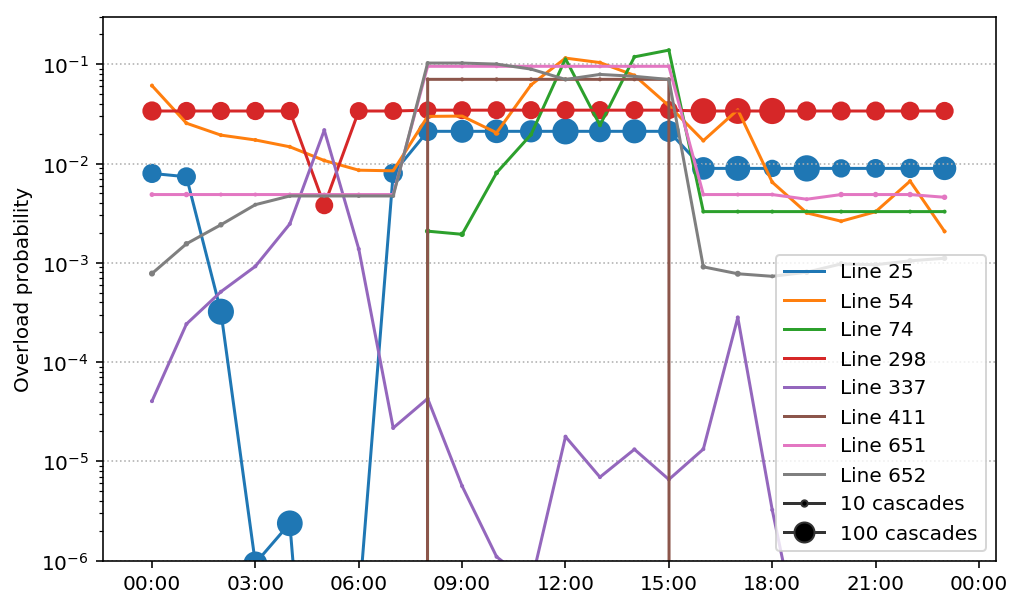

In [116]:
fig, ax = plt.subplots(figsize=(8,5))

for l in tqdm(sorted(riskiest3)):
    probs = []
    cascadeSizes = []
    for t, rating in enumerate(ratings):
        probs.append(rating["P>1"][l])
        
        bus_cov = bus_diff_cov_day if fav_sgn.isdaylighthour[t] else bus_diff_cov_night
        cs = 0
        try:
            cs = len(list(fav_sgn.simulate_cascade(l, bus_cov, time=times[t]))[-1][0])
        except np.linalg.LinAlgError:
            cs = 0
        cascadeSizes.append(cs)
    alpha = 1.0 if l in riskiest3 else .3
    ax.plot(times, probs, label="Line {}".format(l), alpha=alpha)
    ax.scatter(times, probs, s=cascadeSizes, alpha=alpha)

ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M"))

ax.grid(axis="y", linestyle=":")
ax.set_yscale("log")
ax.set_ylim(1e-6,.3)
ax.set_ylabel("Overload probability")

handles, labels = ax.get_legend_handles_labels()
top3 = [(h, l) for h, l in zip(handles, labels) if any(l.endswith(str(l3)) for l3 in riskiest3)]

top3 += [(matplotlib.lines.Line2D([0], [0], marker='o', color='.2', markerfacecolor='0', markersize=np.sqrt(10)), "10 cascades"),
         (matplotlib.lines.Line2D([0], [0], marker='o', color='.2', markerfacecolor='0', markersize=10), "100 cascades")]

ax.legend(*zip(*top3), loc="lower right")

plt.savefig("evolution_overload_probs_3.pdf", bbox_inches="tight")

100%|██████████████████████████████████████████████████████████████████████████████████| 49/49 [02:57<00:00,  3.67s/it]


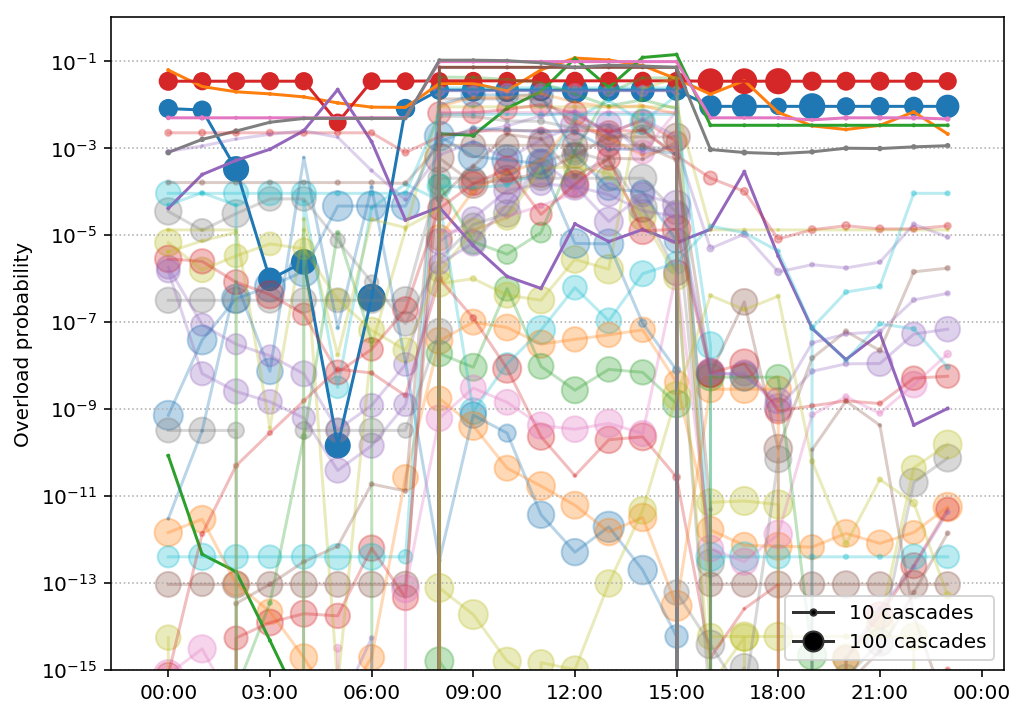

In [117]:
fig, ax = plt.subplots(figsize=(8,6))

for l in tqdm(sorted(riskiest3) + sorted(riskiest20 - riskiest3)):
    probs = []
    cascadeSizes = []
    for t, rating in enumerate(ratings):
        probs.append(rating["P>1"][l])
        
        bus_cov = bus_diff_cov_day if fav_sgn.isdaylighthour[t] else bus_diff_cov_night
        cs = 0
        try:
            cs = len(list(fav_sgn.simulate_cascade(l, bus_cov, time=times[t]))[-1][0])
        except np.linalg.LinAlgError:
            cs = 0
        cascadeSizes.append(cs)
    alpha = 1.0 if l in riskiest3 else .3
    ax.plot(times, probs, label="Line {}".format(l), alpha=alpha)
    ax.scatter(times, probs, s=cascadeSizes, alpha=alpha)

ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M"))
# ax.legend(loc="lower right")
ax.grid(axis="y", linestyle=":", which="both")
ax.set_yscale("log")
ax.set_ylim(1e-15,1)
ax.set_ylabel("Overload probability")

handles, labels = ax.get_legend_handles_labels()
top3 = [(h, l) for h, l in zip(handles, labels) if any(l.endswith(str(l3)) for l3 in riskiest3)]

top3 = [(matplotlib.lines.Line2D([0], [0], marker='o', color='.2', markerfacecolor='0', markersize=np.sqrt(10)), "10 cascades"),
         (matplotlib.lines.Line2D([0], [0], marker='o', color='.2', markerfacecolor='0', markersize=10), "100 cascades")]

ax.legend(*zip(*top3), loc="lower right")

plt.savefig("evolution_overload_probs_3_20.pdf", bbox_inches="tight")

In [120]:
l = 25

cascadeSizes = []
for t, rating in enumerate(ratings):

    bus_cov = bus_diff_cov_day if fav_sgn.isdaylighthour[t] else bus_diff_cov_night
    cs = 0
    try:
        cs = len(list(fav_sgn.simulate_cascade(l, bus_cov, time=times[t]))[-1][0])
    except np.linalg.LinAlgError:
        cs = 0
    cascadeSizes.append(cs)

np.mean(cascadeSizes)

107.58333333333333

In [137]:
offs = fav_sgn.network.generators.source == "Wind Offshore"

In [145]:
fav_sgn.network.generators_t.p_max_pu.loc[:,offs].head(24)

,218 Wind Offshore,221 Wind Offshore,270 Wind Offshore,271 Wind Offshore,22_220kV Wind Offshore
name,,,,,
2011-01-01 00:00:00,1.000000,1.000000,1.000000,0.999568,1.000000
2011-01-01 01:00:00,1.000000,1.000000,1.000000,0.999907,1.000000
2011-01-01 02:00:00,1.000000,1.000000,1.000000,0.999941,1.000000
2011-01-01 03:00:00,1.000000,1.000000,1.000000,0.999947,1.000000
2011-01-01 04:00:00,1.000000,1.000000,1.000000,0.999557,1.000000
2011-01-01 05:00:00,1.000000,1.000000,1.000000,0.989879,1.000000
2011-01-01 06:00:00,1.000000,1.000000,1.000000,0.980983,1.000000
2011-01-01 07:00:00,1.000000,1.000000,1.000000,0.980298,1.000000
2011-01-01 08:00:00,1.000000,1.000000,1.000000,0.983378,1.000000


In [150]:
ratingsIID = []
times = fav_sgn.injection_total.index
for t, time in enumerate(times):
    
    bus_cov = bus_diff_cov_day if fav_sgn.isdaylighthour[t] else bus_diff_cov_night
    bus_cov = np.diag(np.diag(bus_cov))
    
    rating = sgn.get_line_ratings(bus_cov, time=time)
    ratingsIID.append(rating)

In [151]:
riskiest3IID = set()
riskiest20IID = set()

for time, rating in zip(times, ratingsIID):
    riskiest3IID |= set(rating.sort_values("rate", ascending=True).head(3).index)
    riskiest20IID |= set(rating.sort_values("rate", ascending=True).head(20).index)

In [167]:
fullcov_colors = {l: next(ax._get_lines.prop_cycler)["color"] for l in sorted(riskiest3)}
fullcov_colors

{25: '#9467bd',
 54: '#8c564b',
 74: '#e377c2',
 298: '#7f7f7f',
 337: '#bcbd22',
 411: '#17becf',
 651: '#1f77b4',
 652: '#ff7f0e'}

100%|██████████████████████████████████████████████████████████████████████████████████| 42/42 [02:12<00:00,  1.62s/it]


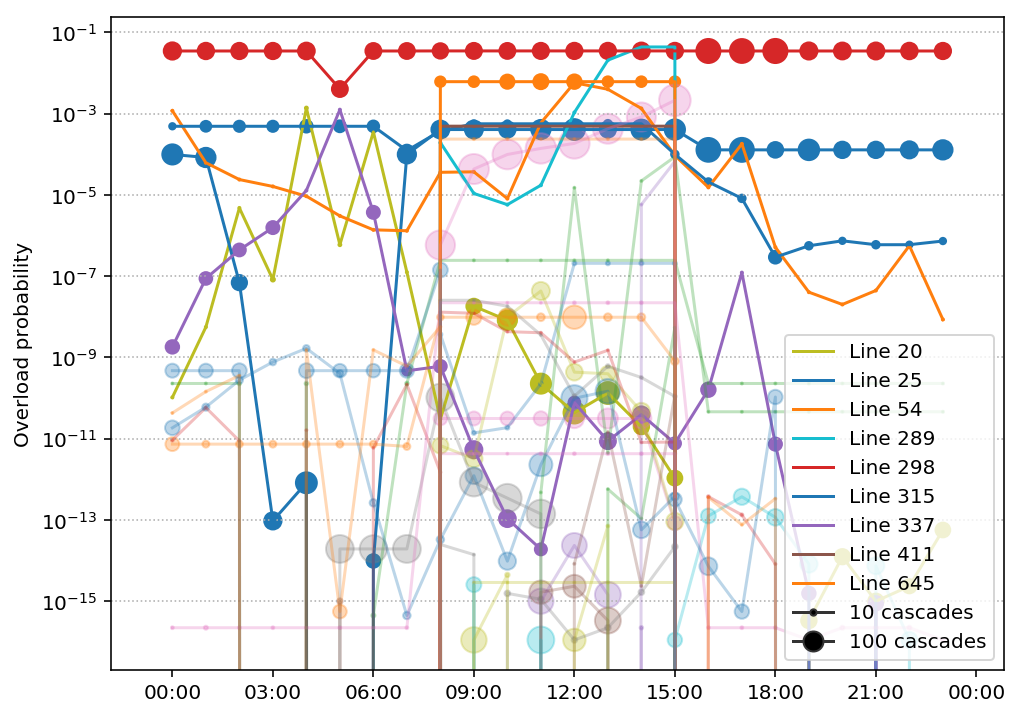

In [170]:
fig, ax = plt.subplots(figsize=(8,6))

fullcov_colors = {l: next(ax._get_lines.prop_cycler)["color"] for l in sorted(riskiest3)}

for l in tqdm(sorted(riskiest3IID) + sorted(riskiest20IID - riskiest3IID)):
    probs = []
    cascadeSizes = []
    for t, rating in enumerate(ratingsIID):
        probs.append(rating["P>1"][l])
        
        bus_cov = bus_diff_cov_day if fav_sgn.isdaylighthour[t] else bus_diff_cov_night
        bus_cov = np.diag(np.diag(bus_cov))
        cs = 0
        try:
            cs = len(list(fav_sgn.simulate_cascade(l, bus_cov, time=times[t]))[-1][0])
        except np.linalg.LinAlgError:
            cs = 0
        cascadeSizes.append(cs)
    alpha = 1.0 if l in riskiest3IID else .3
    
    c = fullcov_colors[l] if l in fullcov_colors else next(ax._get_lines.prop_cycler)["color"]
    ax.plot(times, probs, label="Line {}".format(l), color=c, alpha=alpha)
    ax.scatter(times, probs, s=cascadeSizes, color=c, alpha=alpha)

ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%H:%M"))
# ax.legend(loc="lower right")
ax.grid(axis="y", linestyle=":", which="both")
ax.set_yscale("log")
#ax.set_ylim(1e-15,1)
ax.set_ylabel("Overload probability")

handles, labels = ax.get_legend_handles_labels()
top3 = [(h, l) for h, l in zip(handles, labels) if any(l.endswith(str(l3)) for l3 in riskiest3IID)]

top3 += [(matplotlib.lines.Line2D([0], [0], marker='o', color='.2', markerfacecolor='0', markersize=np.sqrt(10)), "10 cascades"),
         (matplotlib.lines.Line2D([0], [0], marker='o', color='.2', markerfacecolor='0', markersize=10), "100 cascades")]

ax.legend(*zip(*top3), loc="lower right")

plt.savefig("evolution_overload_probs_3_20_IID.pdf", bbox_inches="tight")

In [181]:
fav_sgn.most_likely_power_injection_given_line_failure(251, bus_cov) - fav_sgn.injection_total.iloc[11,:]

0     -4.281972e+01
1     -8.490492e+01
2     -8.509131e+01
3     -4.619828e+01
4     -9.818581e-05
5     -1.262991e-03
6     -6.350955e+00
7     -1.092472e-02
8     -1.695068e-04
9     -1.363676e-02
10    -1.280484e-02
11    -7.088721e+00
12    -8.918358e-01
13    -1.241625e+01
14    -2.441089e+02
15    -1.531313e-03
16    -7.334453e-03
17    -1.742867e+01
18    -1.431412e+01
19    -3.528731e-02
20    -6.123246e-02
21    -4.882355e-01
22    -7.311822e+00
23    -2.371903e+01
24    -2.931239e+00
25    -2.103505e+01
26    -9.561344e-01
27    -1.699755e-02
28    -1.432803e-03
29    -1.744241e-01
           ...     
459    3.871178e+01
460    8.385504e+01
461    1.297327e+02
462    3.766986e+01
463   -3.009647e+01
464   -1.114878e+02
465    9.557935e+00
466    9.480705e+00
467   -9.738975e+00
468    9.864500e-01
469    6.557658e+01
470   -8.808309e+00
471   -2.954329e+00
472   -3.878054e+00
473   -5.106848e+01
474   -1.086853e-01
475   -2.156396e+01
476   -3.973689e-02
477   -1.138789e-04


0     -153.724693
1       19.707911
2      326.636884
3      209.377387
4     -135.435987
5      -81.286139
6      -56.329298
7      -62.116565
8      -33.860897
9        6.313488
10     -37.755318
11     363.223095
12      50.754786
13     -20.769533
14      95.158060
15     -33.466966
16     -70.091782
17     -59.902999
18     965.265780
19    -110.850756
20     -96.273544
21    -157.210801
22      -4.794131
23     -89.238143
24     -10.398083
25     -13.184291
26     858.792434
27     -38.200702
28     -84.812960
29    -206.471453
          ...    
459    823.701132
460    440.801243
461    549.841369
462    134.991307
463    -14.693380
464     44.825981
465     -0.644407
466    210.567949
467     -0.149718
468    -55.487457
469    250.772389
470     -3.336439
471   -160.201996
472     39.220940
473    -35.780723
474    -29.472477
475    -47.894619
476    -59.906754
477    -76.187134
478     10.956652
479    -61.271504
480    -29.519661
481    -16.375697
482     59.526494
483    -40